# Activity recognition on the Capture24 dataset

## Training on the spectrogram of the signal

*This section assumes familiarity with [PyTorch](https://pytorch.org/)*

Instead of using the raw triaxial timeseries data, we consider using the [spectrogram](https://en.wikipedia.org/wiki/Spectrogram) of the signal instead, for which we can apply computer vision techniques. Thus we convert the signal recognition task into an image recognition one.

###### Setup

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import median_filter
import scipy.signal
import tempfile
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.backends.cudnn as cudnn
# from tqdm import tqdm
from tqdm.notebook import tqdm
import utils

# For reproducibility
np.random.seed(42)
torch.manual_seed(42)
cudnn.benchmark = True

# Function to plot dict of scores
def plot_scores(scores, xlabel=None, ylabel=None):
    fig, ax = plt.subplots()
    for key, vals in scores.items():
        ax.plot(vals, label=key)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.legend()
    return fig, ax

 ###### Grab a GPU if there is one 

In [2]:
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("Using {} device: {}".format(device, torch.cuda.current_device()))
else:
    device = torch.device("cpu")
    print("Using {}".format(device))

Using cpu


 ###### Load raw dataset 

In [3]:
# data = np.load('capture24.npz', allow_pickle=True)
data = np.load('capture24_small.npz', allow_pickle=True)
print("Contents of capture24.npz:", data.files)
y, pid, time = data['y'], data['pid'], data['time']
# X = utils.load_raw('X_raw.dat')
X = np.load('X_raw_small.npy')
print("Raw dataset shape:", X.shape)

Contents of capture24.npz: ['X_feats', 'y', 'pid', 'time', 'annotation']
Raw dataset shape: (11016, 3, 3000)


 ###### Generate spectrograms

We use [scipy.signal.stft](https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.stft.html) to generate the spectrograms. The arguments `nperseg` and `noverlap` determine the image size of the spectrogram. For `nperseg=256` and `noverlap=232`, the spectrogram size is $129\times 126$. The function also has a `detrend` argument to detrend each segment of the signal. See [scipy.signal.stft](https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.stft.html) for more details.

The spectrograms are generated by chunks to avoid blowing up the memory, and the resulting dataset is memmap-ed onto a temporary file.
*Tip:* Generating the spectrograms takes quite some time. Alternatively, memmap onto a normal file and just load the file in subsequent runs to avoid repeating this step.

In [4]:
NPERSEG, NOVERLAP = 256, 232  # this results in a spectrogram of size 129x126
Z = np.memmap(
    tempfile.TemporaryFile(),
    mode='w+', dtype=X.dtype,
    shape=(X.shape[0], X.shape[1], NPERSEG//2+1, X.shape[-1]//(NPERSEG-NOVERLAP)+1)
)
for i in tqdm(range(0, len(X), 4096)):
    _, _, Z_batch = scipy.signal.stft(X[i:i+4096],
        nperseg=NPERSEG, noverlap=NOVERLAP, axis=-1, detrend='constant')
    Z_batch = np.log(np.abs(Z_batch) + 1e-16)
    Z[i:i+4096] = Z_batch
    Z.flush()
Z.flags.writeable = False
print("Spectrogram dataset shape:", Z.shape)


Spectrogram dataset shape: (11016, 3, 129, 126)


 ###### Visualization

Let us visualize a few spectrograms for each activity class:

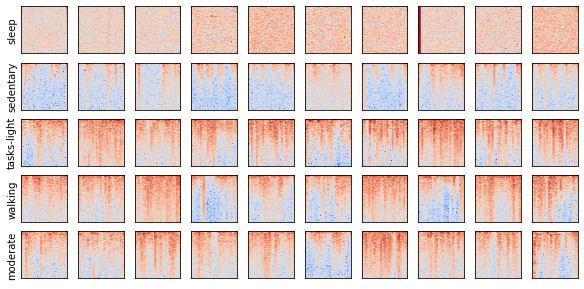

In [5]:
NUM_PLOTS = 10
fig, axs = plt.subplots(utils.NUM_CLASSES, 10, figsize=(10,5))
for i in range(utils.NUM_CLASSES):
    axs[i,0].set_ylabel(utils.CLASSES[i])
    idxs = np.where(y==i)[0]
    for j in range(NUM_PLOTS):
        z = Z[idxs[j]][0]  # spectrogram of the x-axis
        axs[i,j].imshow(z, cmap='coolwarm')
        axs[i,j].set_xticks([])
        axs[i,j].set_yticks([])
fig.show()
fig.savefig('spectrogram.png')

 ## Image classification of spectrograms for activity recognition

The rest of this notebook is identical to the previous notebook on neural networks except for the model architecture, which is now using 2D convolutions and expecting images.

###### Hold out some instances for testing

In [6]:
# Hold out some participants for testing the model
pids_test = [2, 3]
mask_test = np.isin(pid, pids_test)
mask_train = ~mask_test
y_train, y_test = y[mask_train], y[mask_test]
pid_train, pid_test = pid[mask_train], pid[mask_test]
Z_train = utils.ArrayFromMask(Z, mask_train)
Z_test = utils.ArrayFromMask(Z, mask_test)
print("Shape of Z_train", Z_train.shape)
print("Shape of Z_test", Z_test.shape)

Shape of Z_train (6025, 3, 129, 126)
Shape of Z_test (4991, 3, 129, 126)


###### Architecture design

As a baseline model, we use a convolutional neural network (CNN) with a typical pyramid-like structure. The input to the network is a `(N,3,129,126)` array, corresponding to `N` spectrogram images of activity signals. The output of the network is a `(N,5)` array representing predicted *class scores* for each instance.
To obtain probabilities, we can pass each row to a softmax. Then to report a class label, we can pick the highest probability in each row. We output class scores instead of class probabilities or labels because the loss function that we will use operates on the scores (see further below).

In [7]:
class CNN(nn.Module):
    def __init__(self, output_size=5, in_channels=3, num_filters_init=8):
        super(CNN, self).__init__()

        self.cnn = nn.Sequential(
            nn.Conv2d(in_channels, num_filters_init,
                (5,4), 2, 1, bias=False),  # 64,63
            nn.BatchNorm2d(num_filters_init),
            nn.ReLU(True),
            nn.Conv2d(num_filters_init, num_filters_init*2,
                (4,3), 2, 1, bias=False),  # 32,32
            nn.BatchNorm2d(num_filters_init*2),
            nn.ReLU(True),
            nn.Conv2d(num_filters_init*2, num_filters_init*4,
                4, 2, 1, bias=False),  # 16,16
            nn.BatchNorm2d(num_filters_init*4),
            nn.ReLU(True),
            nn.Conv2d(num_filters_init*4, num_filters_init*8,
                4, 2, 1, bias=False),  # 8,8
            nn.BatchNorm2d(num_filters_init*8),
            nn.ReLU(True),
            nn.Conv2d(num_filters_init*8, num_filters_init*16,
                4, 2, 1, bias=False),  # 4,4
            nn.BatchNorm2d(num_filters_init*16),
            nn.ReLU(True),
            nn.Conv2d(num_filters_init*16, num_filters_init*32,
                4, 1, 0, bias=False),  # 1,1
            nn.BatchNorm2d(num_filters_init*32),
            nn.ReLU(True),
            nn.Conv2d(num_filters_init*32, output_size,
                1, 1, 0, bias=True),  # 1,1
        )

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, (nn.BatchNorm2d, nn.GroupNorm)):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

    def forward(self, x):
        return self.cnn(x).view(x.shape[0],-1)

###### Helper functions

We need a few helper functions:
- A data loader that will provide the mini-batches during training.
- A helper function that forward-passes the model on a dataset by chunks &mdash; this is simply to prevent the memory from blowing up.
- A function to train a Hidden Markov Model (HMM) using the probabilistic predictions of the model for smoothing.
- A function that evaluates the model (CNN + HMM) on a dataset, to be used to track the performance during training.

In [8]:
def create_dataloader(Z, y=None, batch_size=1, shuffle=False):
    ''' Create a (batch) iterator over the dataset. Alternatively, use PyTorch's
    Dataset and DataLoader classes -- See
    https://pytorch.org/tutorials/beginner/data_loading_tutorial.html '''
    if shuffle:
        idxs = np.random.permutation(np.arange(len(Z)))
    else:
        idxs = np.arange(len(Z))
    for i in range(0, len(idxs), batch_size):
        idxs_batch = idxs[i:i+batch_size]
        Z_batch = torch.from_numpy(Z[idxs_batch])
        if y is None:
            yield Z_batch
        else:
            y_batch = torch.from_numpy(y[idxs_batch])
            yield Z_batch, y_batch

def forward_by_batches(cnn, Z):
    ''' Forward pass model on a dataset. Do this by batches so that we do
    not blow up the memory. '''
    Y = []
    cnn.eval()
    with torch.no_grad():
        for z in create_dataloader(Z, batch_size=1024, shuffle=False):  # do not shuffle here!
            z = z.to(device)
            Y.append(cnn(z))
    cnn.train()
    Y = torch.cat(Y)
    return Y

def train_hmm(cnn, Z, y):
    ''' Use the probabilistic predictions of the CNN to compute the Hidden
    Markov Model parameters '''
    Y_pred = forward_by_batches(cnn, Z)  # scores
    Y_pred = F.softmax(Y_pred, dim=1)  # probabilities
    Y_pred = Y_pred.cpu().numpy()  # cast to numpy array
    prior, emission, transition = utils.train_hmm(Y_pred, y)
    return prior, emission, transition

def evaluate_model(cnn, prior, emission, transition, Z, y, pid=None):
    Y_pred = forward_by_batches(cnn, Z)  # scores
    Y_pred = F.softmax(Y_pred, dim=1)  # convert to probabilities
    y_pred = torch.argmax(Y_pred, dim=1)  # convert to classes
    y_pred = y_pred.cpu().numpy()  # cast to numpy array
    y_pred = utils.viterbi(y_pred, prior, emission, transition)  # HMM smoothing
    kappa = utils.cohen_kappa_score(y, y_pred, pid)
    accuracy = utils.accuracy_score(y, y_pred, pid)
    return kappa, accuracy

###### Hyperparameters, model instantiation, loss function and optimizer

Now we set the hyperparameters, instantiate the model, define the loss
function (we use cross entropy for multiclass classification) and optimizer
(we use AMSGRAD &mdash; a variant of SGD).

In [9]:
num_filters_init = 8  # initial num of filters -- see class definition
in_channels = 3  # num of input channels -- equal to 3 for our raw triaxial timeseries
output_size = utils.NUM_CLASSES  # number of classes (sleep, sedentary, etc...)
num_epoch = 10  # num of epochs (full loops though the training set) for SGD training
lr = 1e-3  # learning rate in SGD
batch_size = 32  # size of the mini-batch in SGD

cnn = CNN(
    output_size=output_size,
    in_channels=in_channels,
    num_filters_init=num_filters_init
).to(device)
print(cnn)

loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(cnn.parameters(), lr=lr, amsgrad=True)

CNN(
  (cnn): Sequential(
    (0): Conv2d(3, 8, kernel_size=(5, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(8, 16, kernel_size=(4, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): Conv2d(16, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_

###### Training

Training via mini-batch gradient descent begins here. We loop through the training set `num_epoch` times with the `dataloader` iterator.

In [10]:
loss_history = []
kappa_history = {'train':[], 'test':[]}
accuracy_history = {'train':[], 'test':[]}
for i in tqdm(range(num_epoch)):
    dataloader = create_dataloader(Z_train, y_train, batch_size, shuffle=True)
    for x, target in dataloader:
        x, target = x.to(device), target.to(device)
        cnn.zero_grad()
        output = cnn(x)
        loss = loss_fn(output, target)
        loss.backward()
        optimizer.step()

        # Logging -- cross entropy loss
        loss_history.append(loss.item())

    # -------------------------------------------------------------------------
    # Evaluate performance at the end of each epoch (full loop through the
    # training set). We could also do this at every iteration, but this would
    # be very expensive since we are evaluating on the entire dataset.
    # Aditionally, at the end of each epoch we train a Hidden Markov Model to
    # smooth the predictions of the CNN.
    # -------------------------------------------------------------------------

    prior, emission, transition = train_hmm(cnn, Z_train, y_train)

    # Logging -- performance on train set
    kappa, accuracy = evaluate_model(
        cnn, prior, emission, transition, Z_train, y_train, pid_train)
    kappa_history['train'].append(kappa)
    accuracy_history['train'].append(accuracy)
    # Logging -- performance on test set
    kappa, accuracy = evaluate_model(
        cnn, prior, emission, transition, Z_test, y_test, pid_test)
    kappa_history['test'].append(kappa)
    accuracy_history['test'].append(accuracy)

 ###### Plot score and loss history 

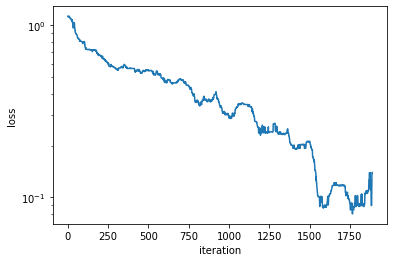

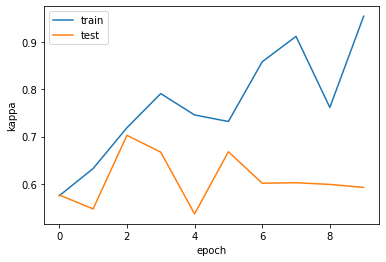

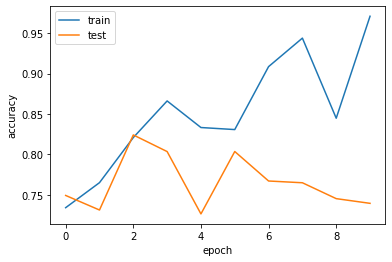

In [11]:
# Loss history
fig, ax = plt.subplots()
ax.semilogy(median_filter(loss_history, size=100))  # smooth for visualization
ax.set_ylabel('loss')
ax.set_xlabel('iteration')
fig.show()
fig.savefig('spectro_loss.png')

# Score history
fig, _ = plot_scores(kappa_history, xlabel='epoch', ylabel='kappa')
fig.show()
fig.savefig('spectro_kappa_scores.png')
fig, _ = plot_scores(accuracy_history, xlabel='epoch', ylabel='accuracy')
fig.show()
fig.savefig('spectro_accuracy_scores.png')

###### Ideas

- Incorporate ideas from the *Neural Networks* notebook, e.g. add the spectrogram of the vector magnitude signal.
- Transfer learning: consider grabbing [available](https://pytorch.org/docs/stable/torchvision/models.html) pre-trained image recognition models and adapting them to our task.

###### References

- [A recipe for training neural networks](http://karpathy.github.io/2019/04/25/recipe/)
- [PyTorch's Conv2d module](https://pytorch.org/docs/stable/nn.html#torch.nn.Conv2d)